In [34]:
%load_ext autoreload
%autoreload 2
from physics_data import generate_harmonic_data
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import json
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# small model local

In [156]:
from model import GPT, GPTConfig
src = "trainings/random_SHO_06Dec24_1104/"
with open(f"{src}/model_cfg.json","r") as fin:
    model_cfg = json.load(fin)
# define model
gpt_config = GPTConfig(**model_cfg)
model = GPT(gpt_config)
model.load_state_dict(torch.load(f"{src}/random_SHO_06Dec24_1104_best.pt",map_location='cpu'))

Using positional embedding
number of parameters: 0.00M


<All keys matched successfully>

In [157]:
from physics_data import RandomSHODataset
masses = torch.arange(0.1,10.1,0.1)
max_seq_length = 75
n_seq = 20
dt = 0.1
val_data = RandomSHODataset(masses,n_seq,max_seq_length,dt,k=8.0)

x = val_data.time_series
ctx = val_data.context

tstart = 10
nstep = max_seq_length - tstart
xcurr = x[:,:tstart,:]
with torch.no_grad():
    for i in range(nstep):
        x_next = model(xcurr,ctx)
        xcurr = torch.cat([xcurr,x_next[:,-1:,:]],dim=1)

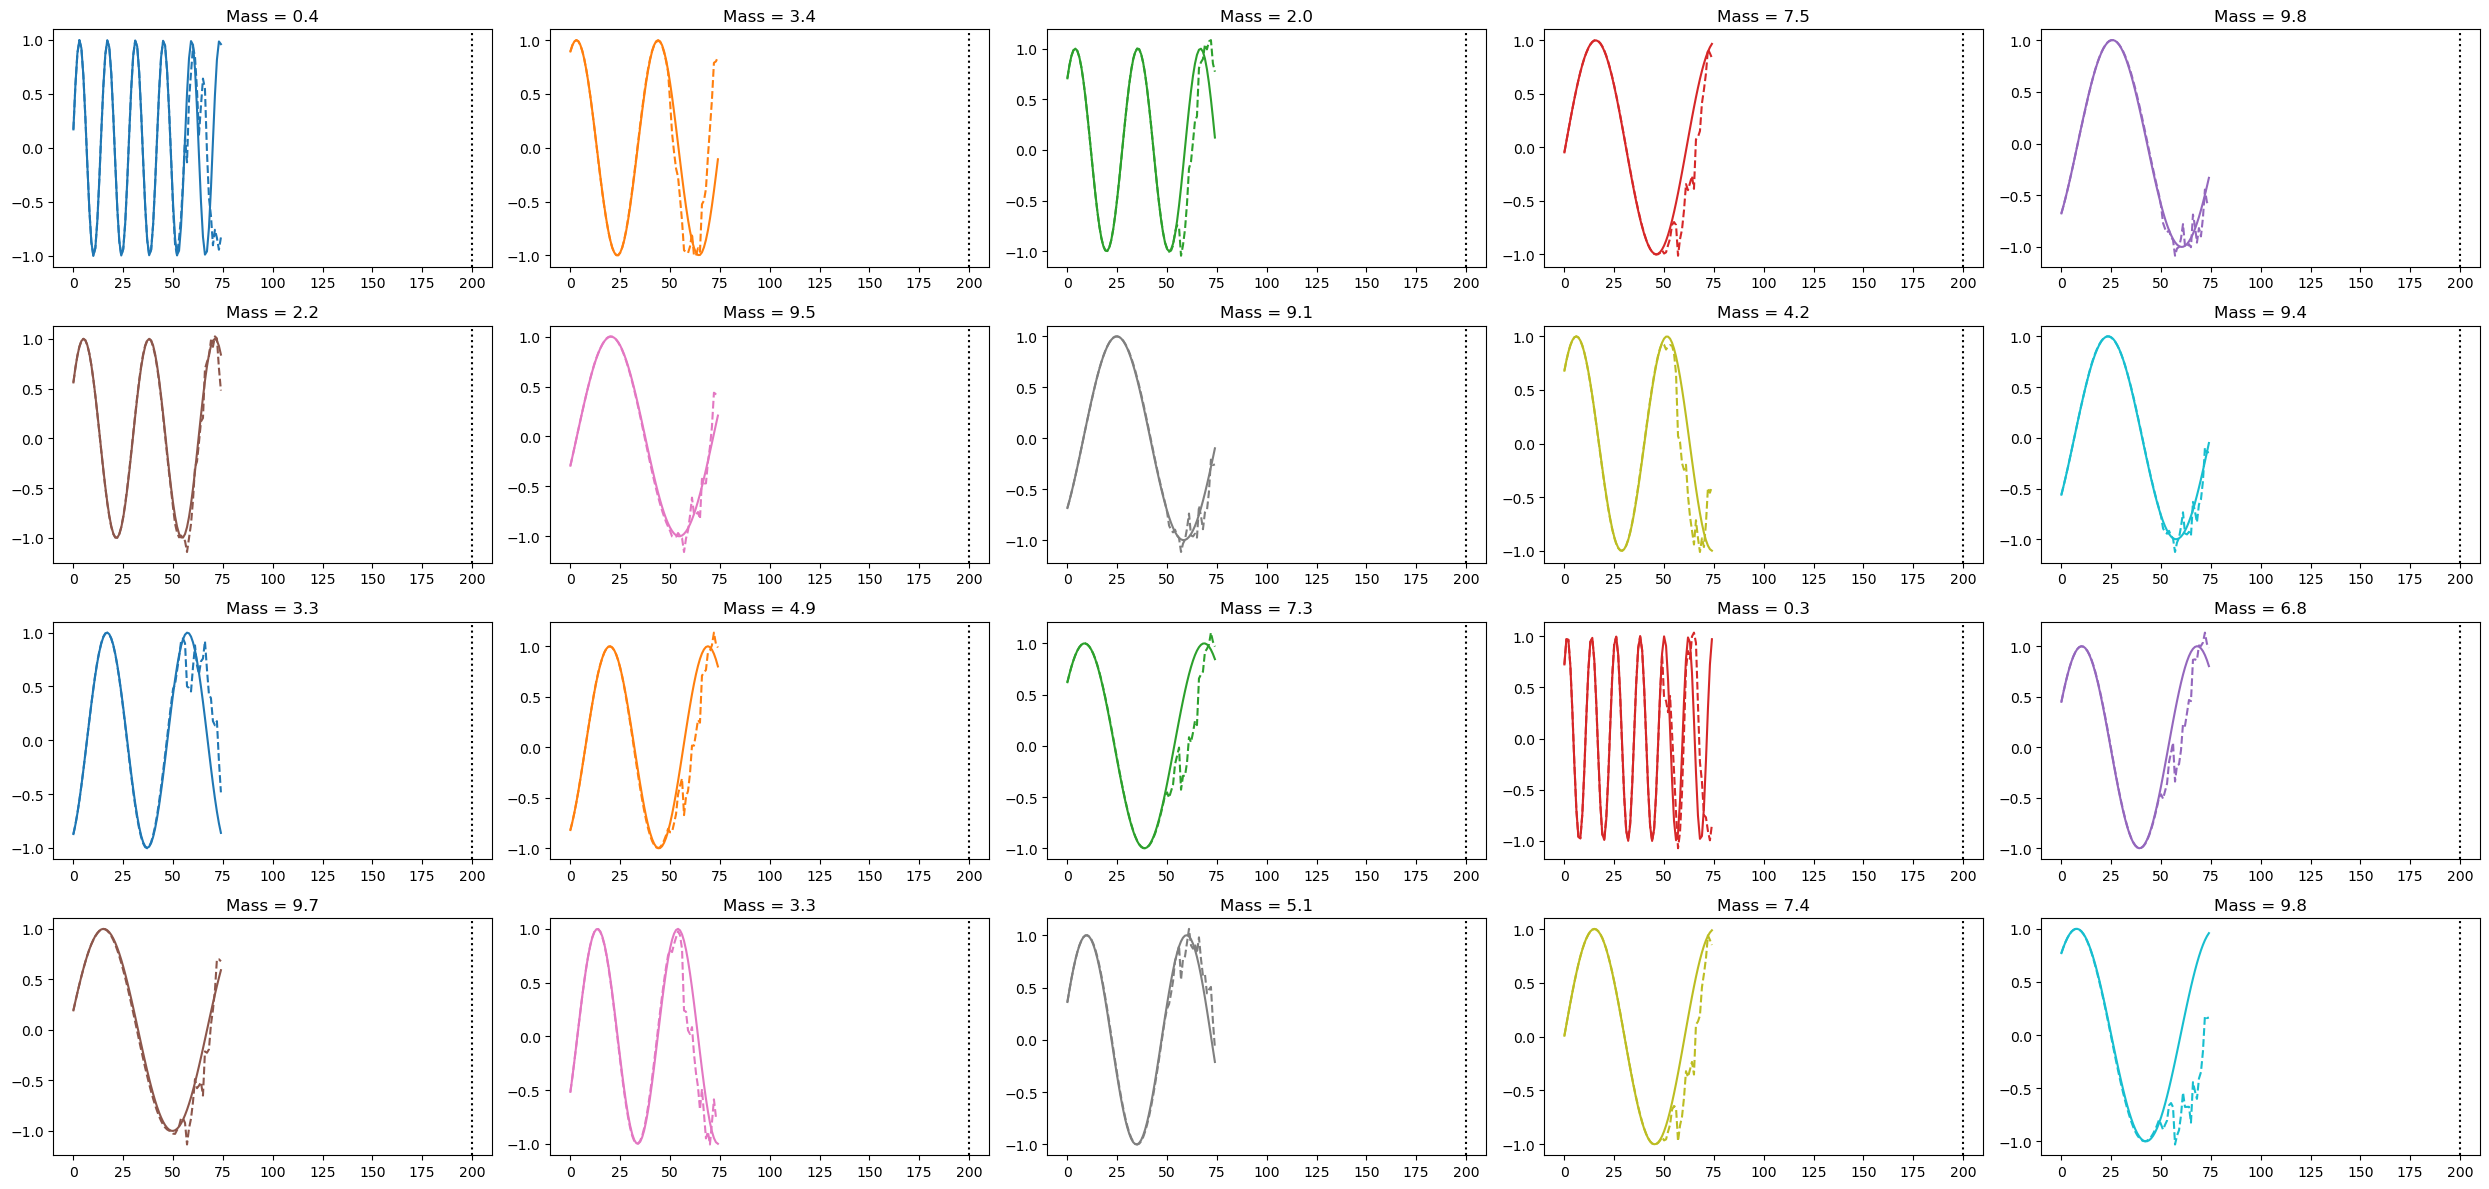

In [158]:
import math

xref = x.squeeze(-1)
xpred = xcurr.squeeze(-1)
tref = np.arange(xref.shape[-1])
tpred = np.arange(xpred.shape[-1])

masses = val_data.rand_masses
n_mass = len(masses)
n_col = 5
n_row = math.ceil(n_mass/n_col)

fig,axes = plt.subplots(n_row,n_col,figsize=(5*n_col,3*n_row))

for idx in range(xref.shape[0]):
    irow = idx//n_col
    icol = idx % n_col
    plt.sca(axes[irow,icol])
    plt.plot(tref,xref[idx:idx+1].T,color=f"C{idx}",zorder=1)
    plt.plot(tpred,xpred[idx:idx+1].T,linestyle='--',color=f"C{idx}",zorder=1)
    plt.title(f"Mass = {masses[idx]:.1f}")
    plt.axvline(200,color='k',linestyle=':',zorder=0)
plt.tight_layout()
#plt.savefig("randMasses_timeSeries_biggerTest.png")

In [66]:
from physics_data import SHODataset
masses = torch.arange(0.1,10.1,0.1)
max_seq_length = 50
n_seq = 20
val_data = SHODataset(masses,max_seq_length,0.1,k=8.0)

x = val_data.time_series
ctx = val_data.context

tstart = 10
nstep = max_seq_length - tstart
xcurr = x[:,:tstart,:]
with torch.no_grad():
    for i in range(nstep):
        x_next = model(xcurr,ctx)
        xcurr = torch.cat([xcurr,x_next[:,-1:,:]],dim=1)

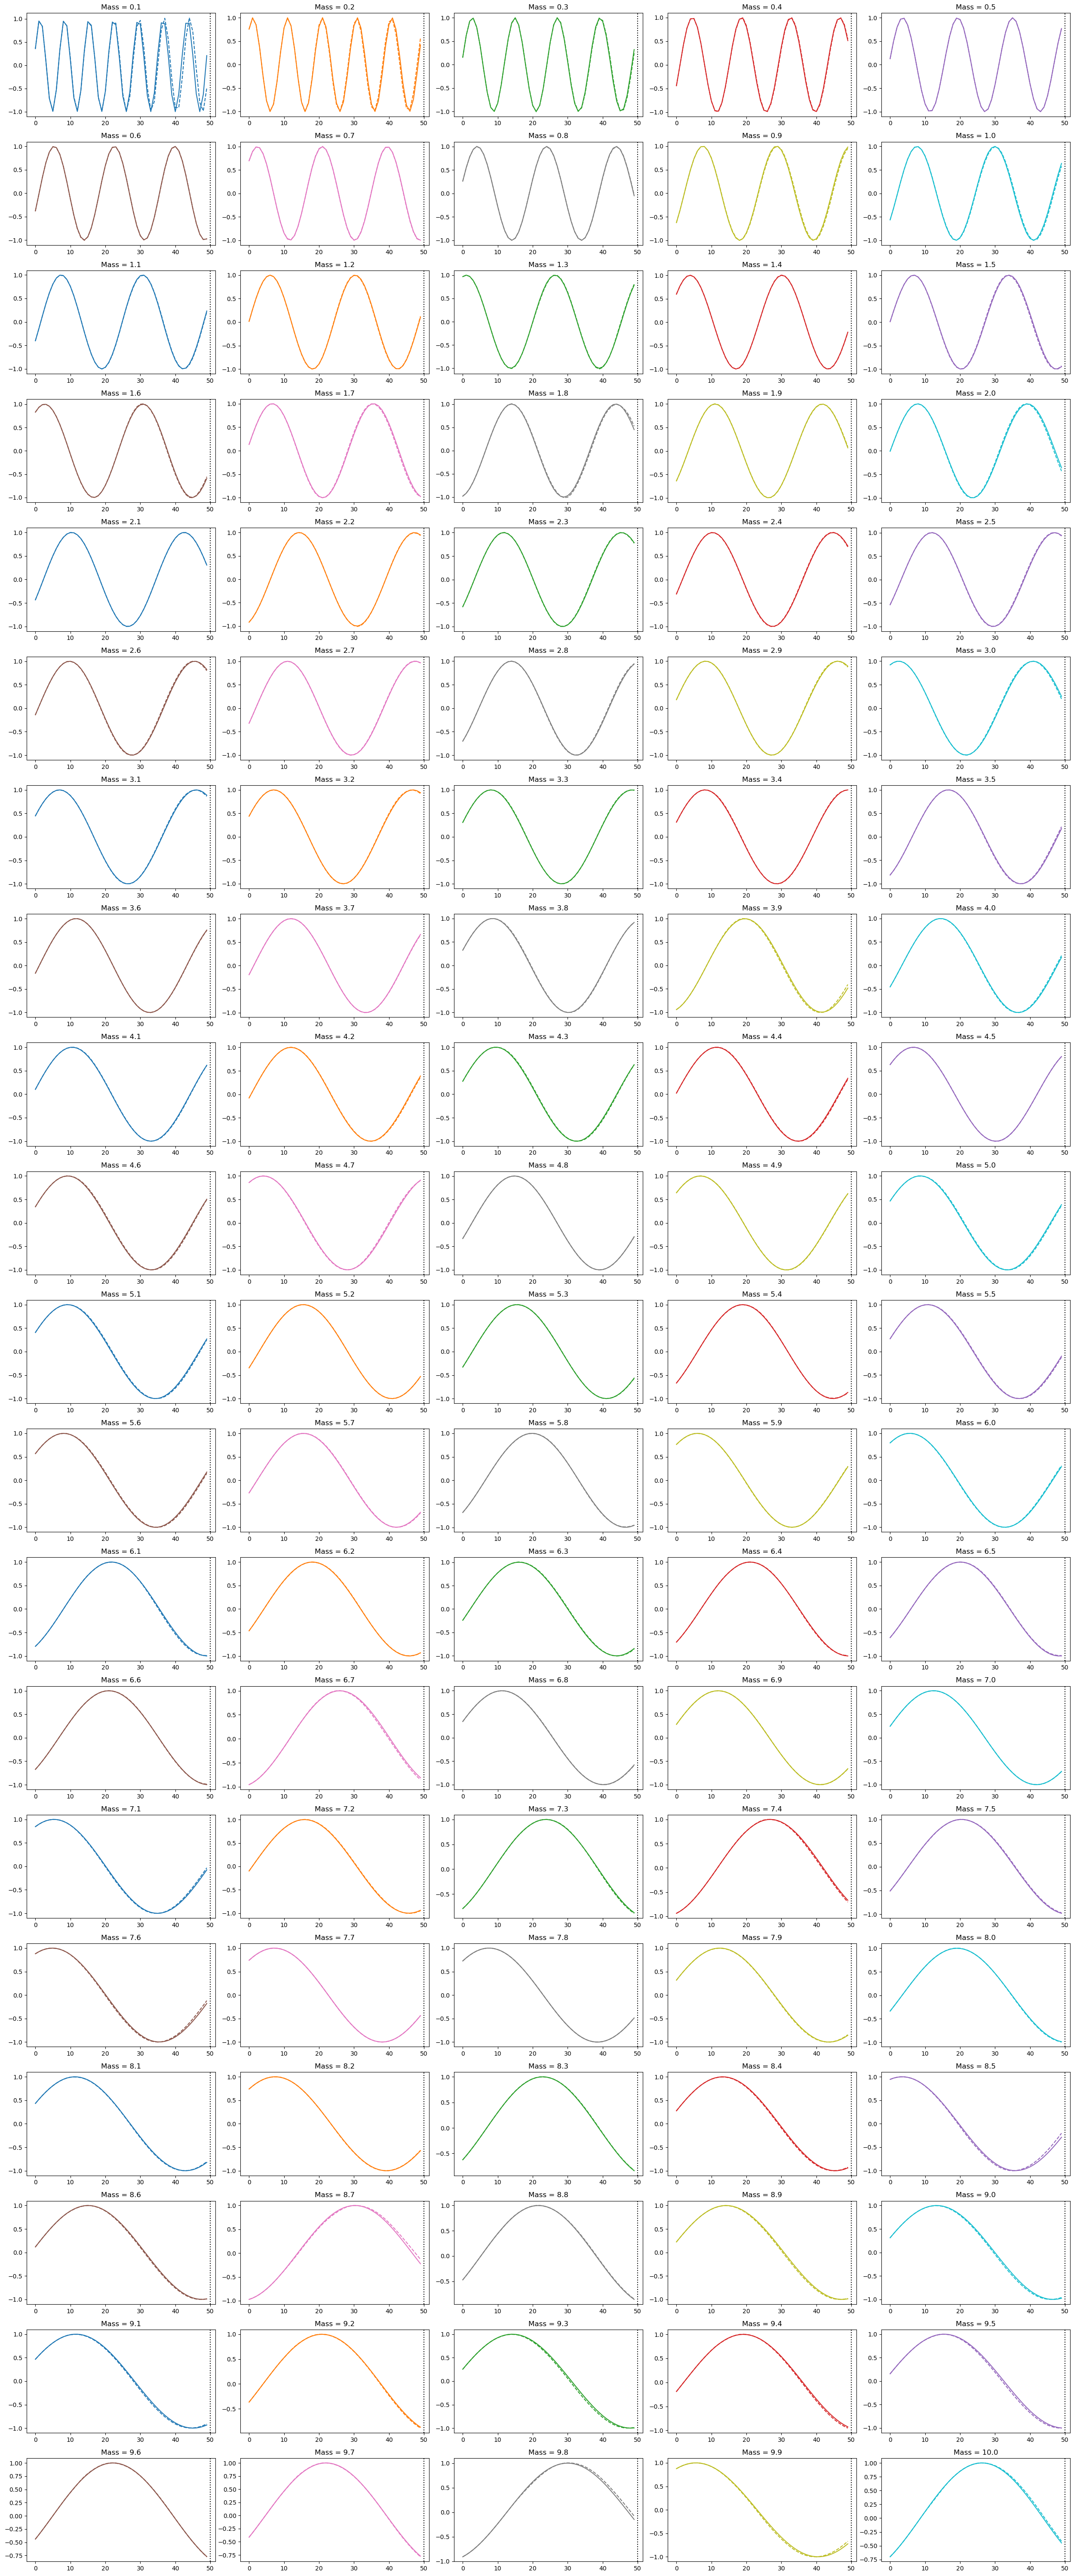

In [68]:
import math

xref = x.squeeze(-1)
xpred = xcurr.squeeze(-1)
tref = np.arange(xref.shape[-1])
tpred = np.arange(xpred.shape[-1])

masses = val_data.masses
n_mass = len(masses)
n_col = 5
n_row = math.ceil(n_mass/n_col)

fig,axes = plt.subplots(n_row,n_col,figsize=(5*n_col,3*n_row))

for idx in range(xref.shape[0]):
    irow = idx//n_col
    icol = idx % n_col
    plt.sca(axes[irow,icol])
    plt.plot(tref,xref[idx:idx+1].T,color=f"C{idx}",zorder=1)
    plt.plot(tpred,xpred[idx:idx+1].T,linestyle='--',color=f"C{idx}",zorder=1)
    plt.title(f"Mass = {masses[idx]:.1f}")
    plt.axvline(50,color='k',linestyle=':',zorder=0)
plt.tight_layout()
plt.savefig("allMasses_timeSeries_smallTest.png")

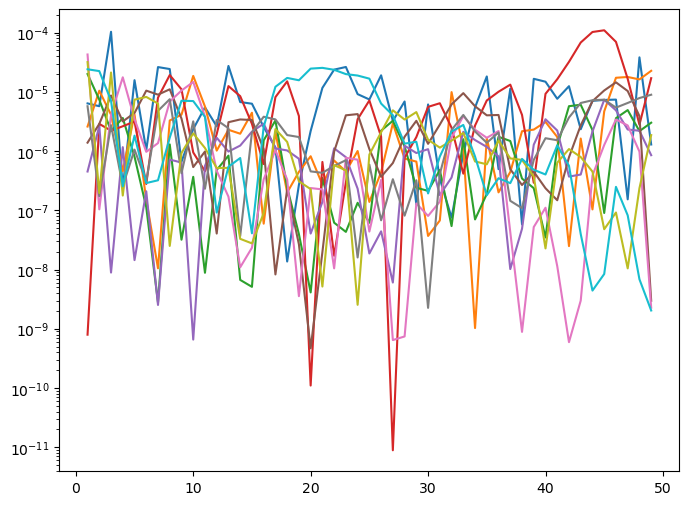

In [73]:
from physics_data import SHODataset
masses = torch.arange(1,11)
max_seq_length = 100
n_seq = 20
val_data = SHODataset(masses,max_seq_length,0.1,k=8.0)

x = val_data.time_series
ctx = val_data.context

ctx_lengths = np.arange(1,50)
mses = []
with torch.no_grad():
    for ctl in ctx_lengths:
        xcurr = x[:,:ctl,:]
        xnext = model(xcurr,ctx)
        mse = (x[:,ctl,:]-xnext[:,-1,:])**2
        mses.append(mse)
mses = torch.cat(mses,dim=1)

plt.figure(figsize=(8,6))
for i,m in enumerate(masses):
    plt.plot(ctx_lengths,mses[i].numpy(),label=f"M = {m:.1f}")
plt.yscale('log')
#plt.legend()

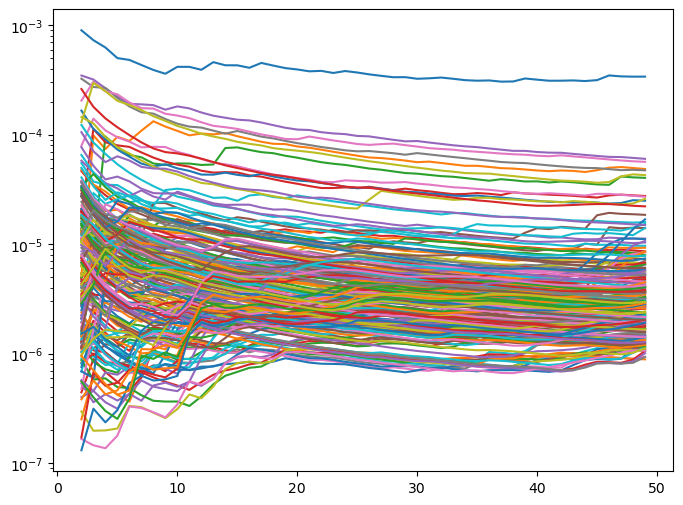

In [129]:
from physics_data import SHODataset
masses = torch.arange(0.1,10.05,0.05)
max_seq_length = 100
n_seq = 20
val_data = SHODataset(masses,max_seq_length,0.1,k=8.0)

x = val_data.time_series
ctx = val_data.context

ctx_lengths = np.arange(2,50)
mses = []
with torch.no_grad():
    for ctl in ctx_lengths:
        xcurr = x[:,:ctl,:]
        xnext = model(xcurr,ctx)
        mse = (x[:,1:ctl+1,:]-xnext)**2
        mses.append(mse.mean(dim=1))
mses = torch.cat(mses,dim=1)

plt.figure(figsize=(8,6))
for i,m in enumerate(masses):
    plt.plot(ctx_lengths,mses[i].numpy(),label=f"M = {m:.1f}")
plt.yscale('log')
#plt.legend(loc='lower right',ncol=4)

Text(0, 0.5, 'Context Length')

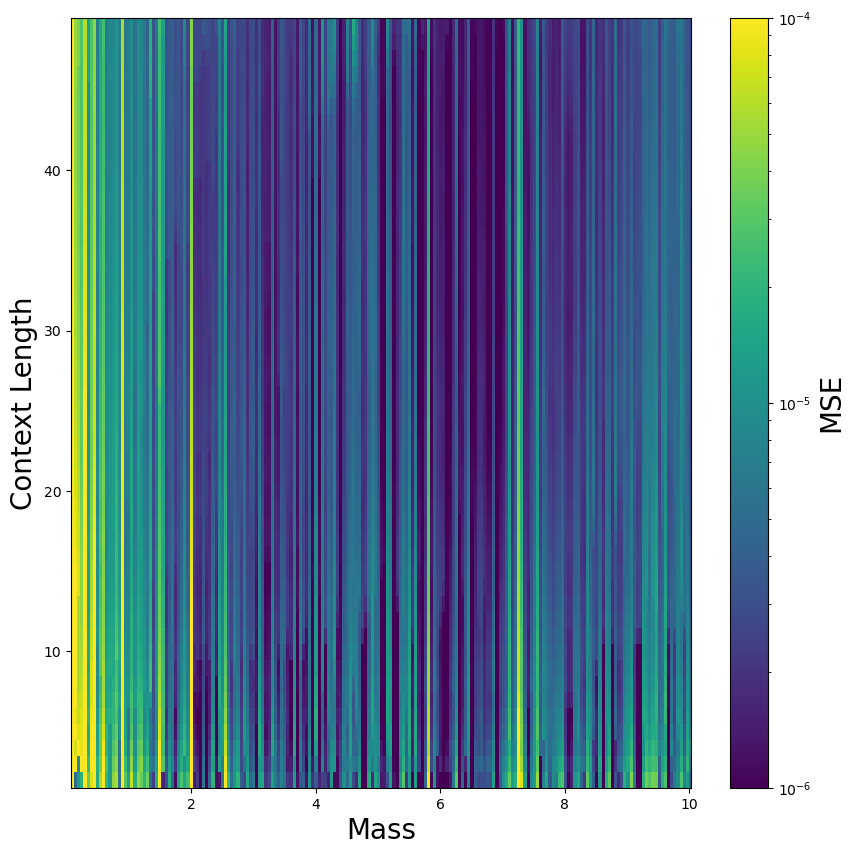

In [131]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(10,10))
extent = [masses[0]-0.5*(masses[1]-masses[0]),masses[-1]+0.5*(masses[1]-masses[0]),
          ctx_lengths[0]-0.5*(ctx_lengths[1]-ctx_lengths[0]),ctx_lengths[-1]+0.5*(ctx_lengths[1]-ctx_lengths[0])]
plt.imshow(mses.T,origin='lower',aspect='auto',norm=LogNorm(vmin=1e-6,vmax=1e-4),extent=extent,cmap='viridis')
cb = plt.colorbar()
cb.set_label(label='MSE', fontsize=20)
plt.xlabel("Mass",fontsize=20)
plt.ylabel("Context Length",fontsize=20)
#t=plt.xticks(np.arange(0.5,10.5,0.5),rotation=25)

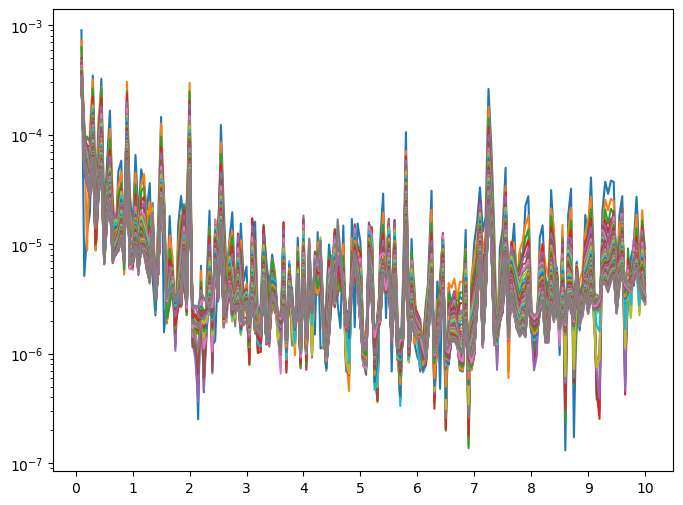

In [132]:
plt.figure(figsize=(8,6))
for i in range(len(ctx_lengths)):
    plt.plot(masses,mses[:,i])
plt.yscale('log')
t=plt.xticks(np.arange(0,11))

# small model, no positional encoding

In [21]:
from model import GPT, GPTConfig
src = "trainings/random_SHO_09Dec24_1217/"
with open(f"{src}/model_cfg.json","r") as fin:
    model_cfg = json.load(fin)
with open(f"{src}/training_cfg.json","r") as fin:
    train_cfg = json.load(fin)
# define model
gpt_config = GPTConfig(**model_cfg)
model = GPT(gpt_config)
model.load_state_dict(torch.load(f"{src}/random_SHO_09Dec24_1217_best.pt",map_location='cpu'))

number of parameters: 0.00M


<All keys matched successfully>

## plot trajectories up to t = 50 for range of masses with $x_0 = 0$

In [52]:
from PhysicsDatasets import SHODataset
masses = torch.arange(0,10.5,0.5)
masses[0] = 0.1
max_seq_length = 75
train_length = 50
n_seq = 20
k = train_cfg['k']
dt = train_cfg['dt']
val_data = SHODataset(masses=masses,seq_len=max_seq_length,dt=dt,k=k, pin_amplitude=1.0)

x = val_data.xt
ctx = val_data.context

tstart = 10
nstep = max_seq_length - tstart
xcurr = x[:,:tstart,:]
with torch.no_grad():
    for i in range(nstep):
        x_next = model(xcurr,ctx)
        xcurr = torch.cat([xcurr,x_next[:,-1:,:]],dim=1)

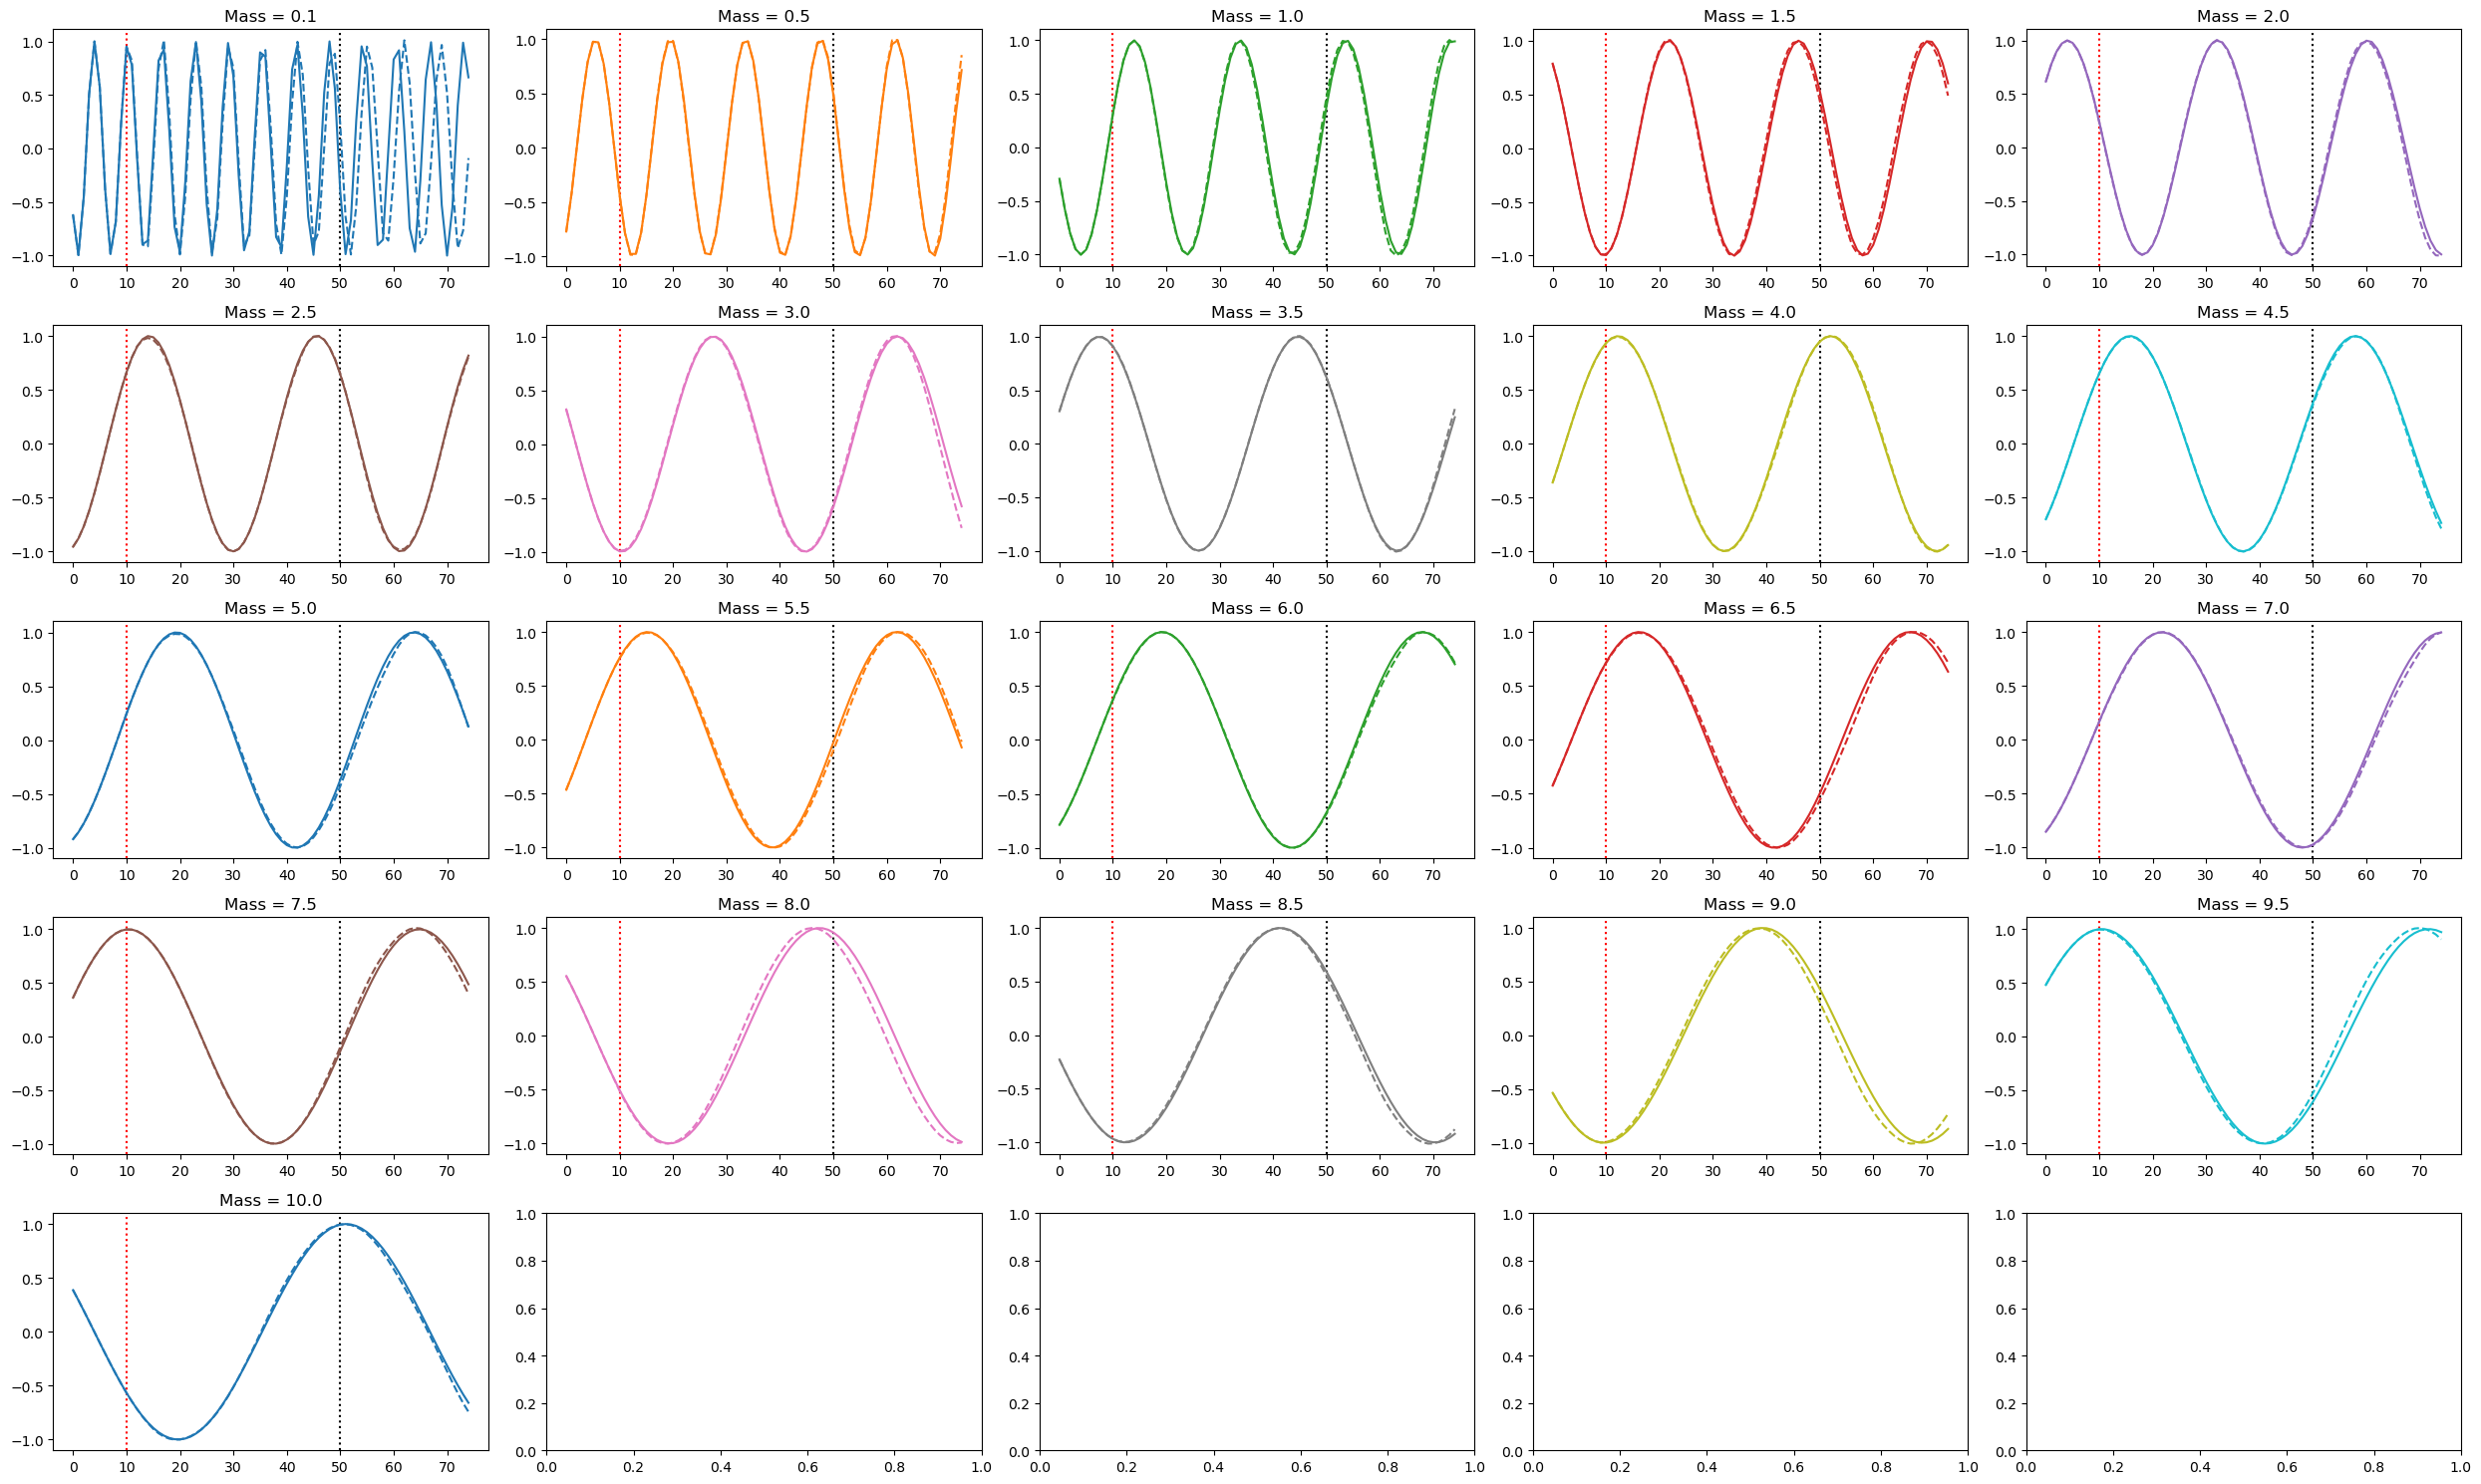

In [53]:
import math

xref = x.squeeze(-1)
xpred = xcurr.squeeze(-1)
tref = np.arange(xref.shape[-1])
tpred = np.arange(xpred.shape[-1])

masses = val_data.masses
n_mass = len(masses)
n_col = 5
n_row = math.ceil(n_mass/n_col)

fig,axes = plt.subplots(n_row,n_col,figsize=(5*n_col,3*n_row))

for idx in range(xref.shape[0]):
    irow = idx//n_col
    icol = idx % n_col
    plt.sca(axes[irow,icol])
    plt.plot(tref,xref[idx:idx+1].T,color=f"C{idx}",zorder=1)
    plt.plot(tpred,xpred[idx:idx+1].T,linestyle='--',color=f"C{idx}",zorder=1)
    plt.title(f"Mass = {masses[idx]:.1f}")
    plt.axvline(train_length,color='k',linestyle=':',zorder=0)
    plt.axvline(tstart,color='red',linestyle=':',zorder=0)
plt.tight_layout()
#plt.savefig("allMasses_timeSeries_smallTest_noPosEnc.png")

## investigate MSE for next-pos-prediction with $x_0 = 0$

In [35]:
from PhysicsDatasets import SHODataset
masses = np.arange(0.1,10.05,0.05)
x0s = torch.linspace(-1,1,50)
max_seq_length = 50

ctx_lengths = np.arange(1,50)
mses_mean = np.zeros((len(masses),len(ctx_lengths)))
mses_final = np.zeros((len(masses),len(ctx_lengths)))
for i,m in tqdm(enumerate(masses)):
    val_data = SHODataset(masses=m,seq_len=max_seq_length,dt=dt,k=k,x0=x0s,pin_amplitude=1.0)
    x = val_data.xt
    ctx = val_data.context
    with torch.no_grad():
        for j,ctl in enumerate(ctx_lengths):
            xcurr = x[:,:ctl,:]
            xnext = model(xcurr,ctx)
            mse = (x[:,1:ctl+1,:]-xnext)**2
            mse = mse.mean(dim=0).squeeze(-1) # mean over the x0s
            mses_mean[i,j] = mse.mean(dim=0) # mean over time
            mses_final[i,j] = mse[-1]

199it [00:15, 13.06it/s]


Text(0, 0.5, 'mean MSE of next pos prediction')

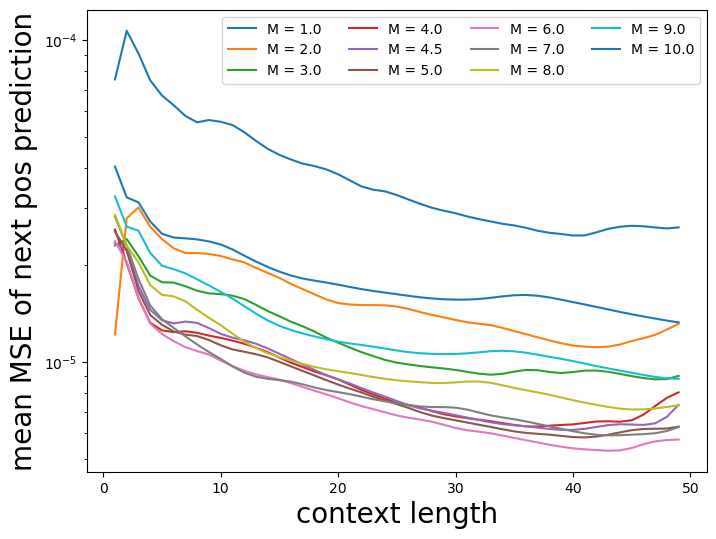

In [44]:
plt.figure(figsize=(8,6))
msel = np.concatenate([np.arange(1,5),np.array([4.5]),np.arange(5,11)])
for i,m in enumerate(masses):
    if np.any(np.isclose(m,msel)):
        plt.plot(ctx_lengths,mses_mean[i],label=f"M = {m:.1f}")
plt.yscale('log')
plt.legend(loc='upper right',ncol=4)
plt.xlabel("context length",fontsize=20)
plt.ylabel("mean MSE of next pos prediction",fontsize=20)

Text(0, 0.5, 'MSE of last pos prediction')

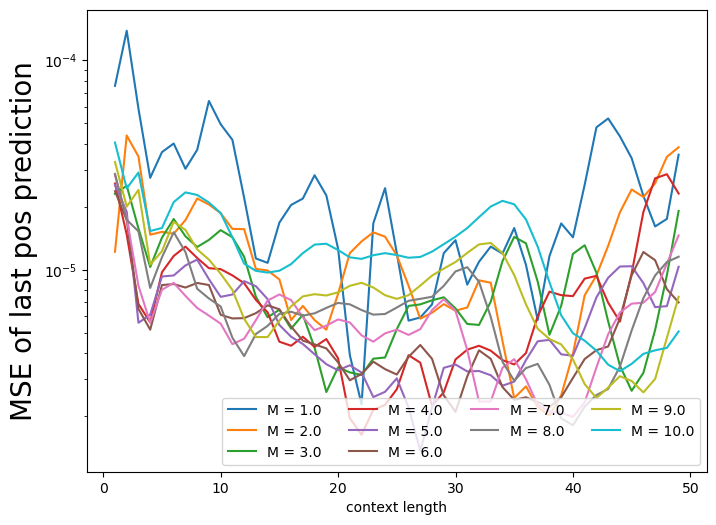

In [45]:
plt.figure(figsize=(8,6))
msel = np.arange(1,11)
for i,m in enumerate(masses):
    if np.any(np.isclose(m,msel)):
        plt.plot(ctx_lengths,mses_final[i],label=f"M = {m:.1f}")
plt.yscale('log')
plt.legend(loc='lower right',ncol=4)
plt.xlabel("context length")
plt.ylabel("MSE of last pos prediction",fontsize=20)

Text(0.5, 1.0, 'x0=0')

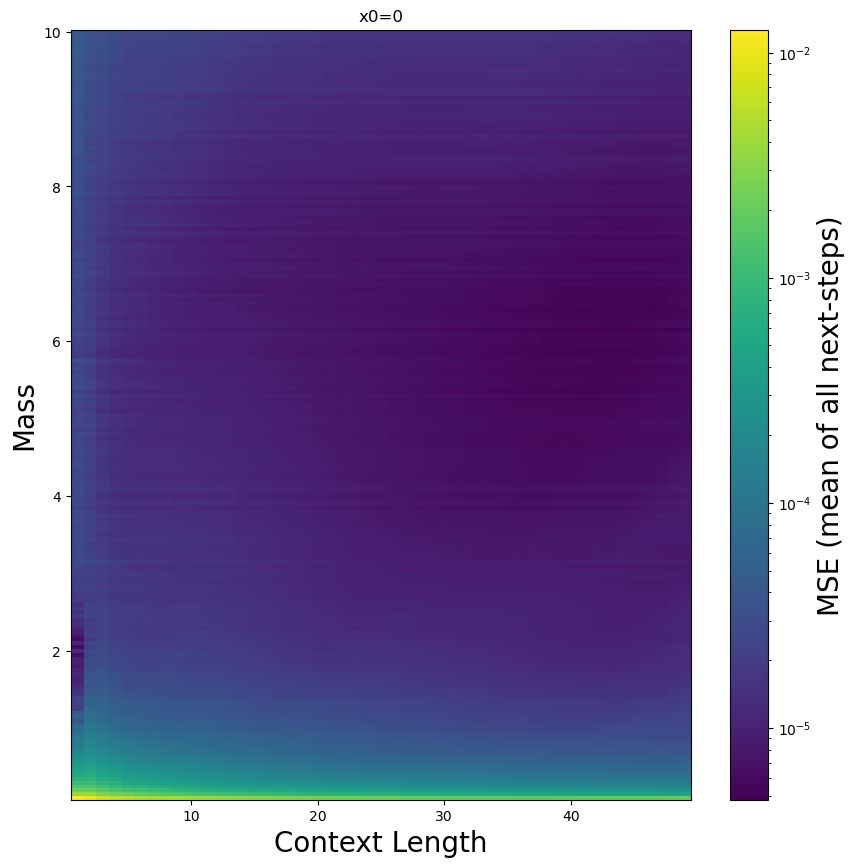

In [46]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(10,10))
extent = [ctx_lengths[0]-0.5*(ctx_lengths[1]-ctx_lengths[0]),ctx_lengths[-1]+0.5*(ctx_lengths[1]-ctx_lengths[0])] + [masses[0]-0.5*(masses[1]-masses[0]),masses[-1]+0.5*(masses[1]-masses[0])]
plt.imshow(mses_mean,origin='lower',aspect='auto',norm=LogNorm(),extent=extent,cmap='viridis')
cb = plt.colorbar()
cb.set_label(label='MSE (mean of all next-steps)', fontsize=20)
plt.ylabel("Mass",fontsize=20)
plt.xlabel("Context Length",fontsize=20)
#t=plt.xticks(np.arange(0.5,10.5,0.5),rotation=25)
plt.title("x0=0")

Text(0.5, 1.0, 'x0 = 0')

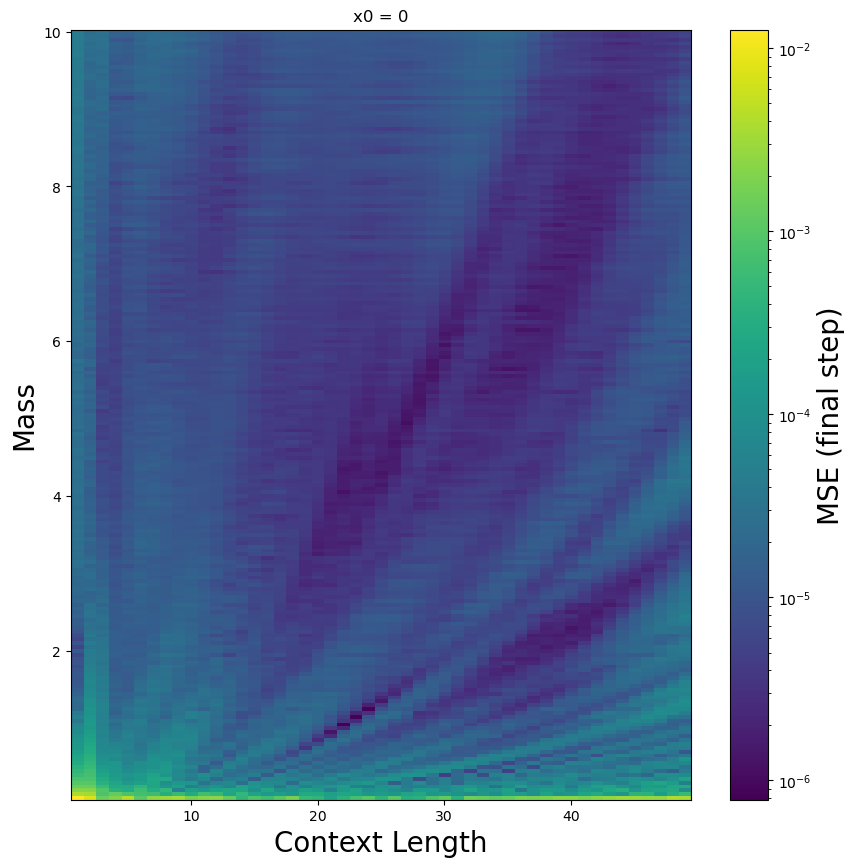

In [47]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(10,10))
extent = [ctx_lengths[0]-0.5*(ctx_lengths[1]-ctx_lengths[0]),ctx_lengths[-1]+0.5*(ctx_lengths[1]-ctx_lengths[0])] + [masses[0]-0.5*(masses[1]-masses[0]),masses[-1]+0.5*(masses[1]-masses[0])]
plt.imshow(mses_final,origin='lower',aspect='auto',norm=LogNorm(),extent=extent,cmap='viridis')
cb = plt.colorbar()
cb.set_label(label='MSE (final step)', fontsize=20)
plt.ylabel("Mass",fontsize=20)
plt.xlabel("Context Length",fontsize=20)
#t=plt.xticks(np.arange(0.5,10.5,0.5),rotation=25)
plt.title("x0 = 0")

In [136]:
a = torch.cat([dset.xt,dset.vt],dim=-1)
a.shape

torch.Size([5, 50, 2])

## fix m = 3, investigate MSE vs context for varying $x_0$

In [11]:
from PhysicsDatasets import SHODataset
#x0 = torch.arange(-1.0,1.01,0.01)
x0 = torch.arange(0,1.01,0.01)
masses = 3.0*torch.ones(x0.shape[0])
max_seq_length = 50
n_seq = 20
val_data = SHODataset(masses=masses,seq_len=max_seq_length,dt=dt,k=k,x0=x0,v0=1,pin_amplitude=1.0)

x = val_data.xt
ctx = val_data.context

ctx_lengths = np.arange(2,50)
mses_mean = []
mses_final = []
with torch.no_grad():
    for ctl in ctx_lengths:
        xcurr = x[:,:ctl,:]
        xnext = model(xcurr,ctx)
        mse = (x[:,1:ctl+1,:]-xnext)**2
        mses_mean.append(mse.mean(dim=1))
        mses_final.append(mse[:,-1,:])
mses_mean = torch.cat(mses_mean,dim=1)
mses_final = torch.cat(mses_final,dim=1)

Text(0.5, 0, 'Context Length')

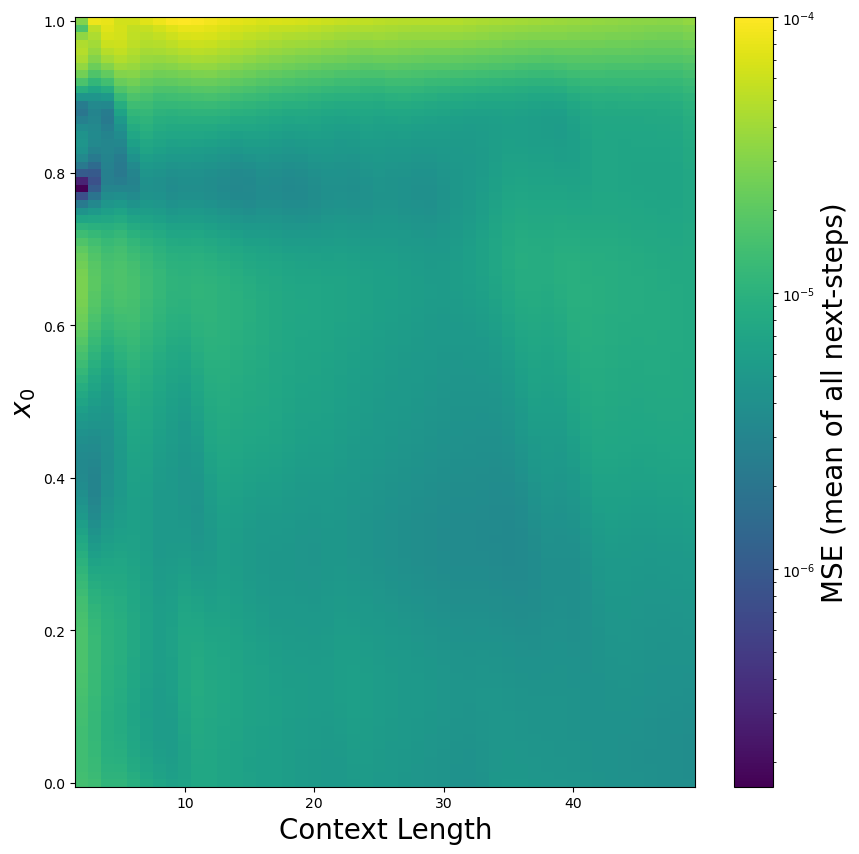

In [12]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(10,10))
extent = [ctx_lengths[0]-0.5*(ctx_lengths[1]-ctx_lengths[0]),ctx_lengths[-1]+0.5*(ctx_lengths[1]-ctx_lengths[0])] + [x0[0]-0.5*(x0[1]-x0[0]),x0[-1]+0.5*(x0[1]-x0[0])]
plt.imshow(mses_mean,origin='lower',aspect='auto',norm=LogNorm(),extent=extent,cmap='viridis')
cb = plt.colorbar()
cb.set_label(label='MSE (mean of all next-steps)', fontsize=20)
plt.ylabel("$x_0$",fontsize=20)
plt.xlabel("Context Length",fontsize=20)
#t=plt.xticks(np.arange(0.5,10.5,0.5),rotation=25)